## Introduction 
In this project, we will walk through some databases that relates to the Covid-19. The ultimate goal of this project is to discuss several key questions regarding the terriible pandemic:
1. What factors can be beneficial in predicting how fast coronavirus spreads in a region?
2. How to model the number of coronavirus cases in a region.


## The Data

The [covid19/4.18states.csv](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data) file contains an aggregation of USA state level data by 4/18/2020. An [explanation](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/README.md) of each variable can be found on the website. 

The [time_series_covid19_.csv](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/README.md) file contains daily time series summary tables, including confirmed and deaths. All data is read in from the daily case report. Two time series tables are for the US confirmed cases and deaths, reported at the county level. 

The [abridged_counties.csv](https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/readme.md) file contains COVID-19 cases/deaths from USA Facts and NYT, automatically updated every day, along with demographic information, health resource availability, COVID-19 health risk factors, and social mobility information. An explanation of variables could be found on [here](https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/list_of_columns.md). 

## Part 1 EDA
In this section, we will make a series of exploratory visualizations and interpret them.

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [3]:
# Covid-19
df1 = pd.read_csv('4.18states.csv')
df2 = pd.read_csv('abridged_couties.csv')
df3 = pd.read_csv('time_series_covid19_confirmed_US.csv')
df4 = pd.read_csv('time_series_covid19_deaths_US.csv')

In [140]:
#YQ
import datetime as dt

# Create new columns in df2/counties:
counties = pd.read_csv('abridged_couties.csv')
# Divide population into three categories based on age: 1, young(<=19), middle-aged(20-59), old(>=60)
Pop5, Pop20, Pop60, Pop84 = counties.columns.get_loc("PopMale<52010"), counties.columns.get_loc("PopMale20-242010"), counties.columns.get_loc("PopMale60-642010"), counties.columns.get_loc("PopMale>842010")

counties['Pop<=19'] = counties.iloc[:,Pop5:Pop20].sum(axis = 1)
counties['Pop20-59'] = counties.iloc[:,Pop20:Pop60].sum(axis = 1)
counties['Pop>=60'] = counties.iloc[:,Pop60:Pop84].sum(axis = 1)

# Change the ordinal date to year-month-day, all original NA values are now '0001-01-01 00:00:00'
Stay_at_home, Foreign_travel_ban = counties.columns.get_loc("stay at home"), counties.columns.get_loc("foreign travel ban")
column_names = ['Date stay at home','Date >50 gatherings', 'Date >500 gatherings', 'Date public schools', 'Date restaurant dine-in', 'Date entertainment/gym', 'Date federal guidelines', 'Date foreign travel ban']
for i in range(Stay_at_home, Foreign_travel_ban+1):
    counties.iloc[:,i] = counties.iloc[:,i].fillna(1).astype(int)
    counties[column_names[i-Stay_at_home]] = counties.iloc[:,i].apply(dt.datetime.fromordinal)


counties = counties.drop([3242,3243])

Below we plotted the confirmed cases and death cases using the data as of 4-18-2020 for states in US and showed the top 20 states. It is noticed that NY state and NJ state ranked first and second in both plot, but the rest were not exactly the same. Generally, more death cases would be expected for states with more confirmed cases, but the plots indicated that the confirmed case is not the only factor to influence this. In the following, we would access what are the important parameters (e.g. hospitals, age distribution, natural mortality, insurance) that influence the mortality rate in different states. 

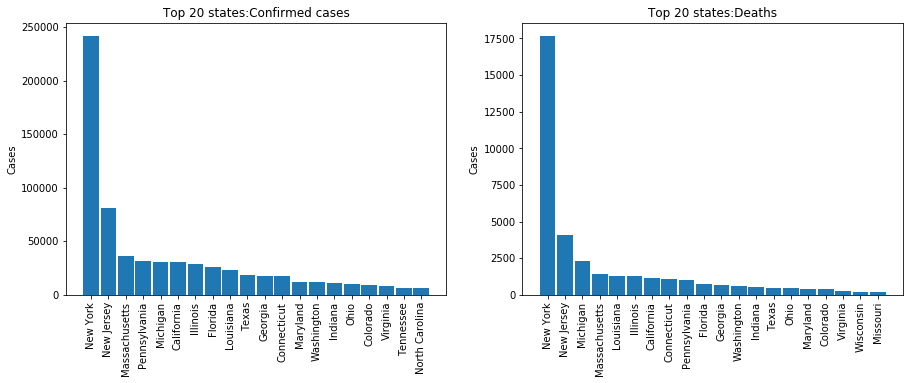

In [141]:
# YQ
US_states = df1[df1['Country_Region'] == 'US'].sort_values(by=['Confirmed'], ascending=False).head(20)
#US_states = US_states.drop(index = 116)
US_states_death = df1[df1['Country_Region'] == 'US'].sort_values(by=['Deaths'], ascending=False).head(20)


f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.bar(US_states['Province_State'], US_states['Confirmed'], width=0.9)
ax1.set_title('Top 20 states:Confirmed cases')

ax2.bar(US_states_death['Province_State'], US_states_death['Deaths'], width=0.9)
ax2.set_title('Top 20 states:Deaths')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    ax.set(ylabel='Cases')
    



First of all, we would like to see the important factors that influence the spread of covid-19 in different counties of NY state.

In [142]:
# YQ
import plotly
plotly.__version__
import plotly.express as px

#df3 = pd.read_csv('time_series_covid19_confirmed_US.csv')
NY_time_series_confirmed = df3[df3['Province_State'] == 'New York']
NY_time_series_confirmed = NY_time_series_confirmed.drop([3181, 3233])
#NY_map_lat = [NY_time_series_confirmed['Lat'].min(), NY_time_series_confirmed['Lat'].max()]
#NY_map_long = [NY_time_series_confirmed['Long_'].min(), NY_time_series_confirmed['Long_'].max()]
NY_time_series_confirmed
# 

plt.figure(figsize=(10,8))
fig = px.scatter(NY_time_series_confirmed, x = 'Lat', y = 'Long_',size = (NY_time_series_confirmed['4/18/20']) ** 0.4, 
                 text=list(NY_time_series_confirmed['Admin2']))
fig['layout']['xaxis']['autorange'] = "reversed"          
                  
fig.update_traces(textposition='top center')
fig.show()

#plt.figure(figsize=(10,8))
#ax = sns.scatterplot(x=NY_time_series_confirmed['Lat'], y=NY_time_series_confirmed['Long_'],
#                    size=(NY_time_series_confirmed['4/18/20']), hue = (NY_time_series_confirmed['4/18/20'])**0.55,
#                    sizes=(20, 200), hue_norm=(0, 7),
#                      data=NY_time_series_confirmed)



<Figure size 720x576 with 0 Axes>

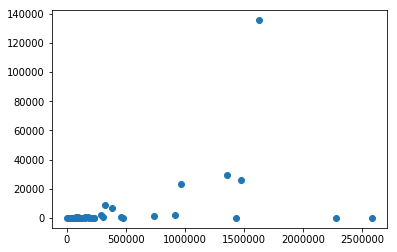

In [166]:
# YQ
NY_time_series_confirmed['FIPS'] = NY_time_series_confirmed['FIPS'].astype(int)

counties['countyFIPS'] = counties['countyFIPS'].astype(int)
NY_counties = counties.merge(NY_time_series_confirmed, left_on = 'countyFIPS', right_on = 'FIPS',how = 'inner')
factors = ['PopulationDensityperSqMile2010', 'MedianAge2010', '#EligibleforMedicare2018', '#ICU_beds',
          'Pop>=60']


def select_columns(data, columns):
    """Select only columns passed as arguments."""
    col = columns[:]
    return data.loc[:, columns]

training_data = select_columns(NY_counties, factors)
training_label = NY_counties['4/18/20']
plt.scatter(x = NY_counties['PopulationEstimate2018'], y = NY_counties['4/18/20'])
#plt.scatter(NY_counties['PopulationDensityperSqMile2010'], NY_counties['4/18/20'])